<a href="https://colab.research.google.com/github/claudiaxpreda/MLStuff/blob/main/Railway_Tracker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



> Mount google drive, where models and the dataset are stored



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
print('Driver mounted')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Driver mounted




> Limit GPU memory to be used when needed



In [ ]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]




> Get folders paths to the dataset from google drive or from local



In [ ]:
def get_dataset_paths(dataset=1):
  if dataset == 1:
    train_ann_dir = os.path.join('drive/My Drive/dataset-1/train/anns')
    train_frames_dir = os.path.join('drive/My Drive/dataset-1/train/frames')
    test_ann_dir = os.path.join('drive/My Drive/dataset-1/test/anns')
    test_frames_dir = os.path.join('drive/My Drive/dataset-1/test/frames')
  else:
    train_ann_dir = os.path.join('dataset/train/anns')
    train_frames_dir = os.path.join('dataset/train/frames')
    test_ann_dir = os.path.join('dataset/test/anns')
    test_frames_dir = os.path.join('dataset/test/frames')

  return(train_ann_dir, train_frames_dir, test_ann_dir, test_frames_dir)

print('Done!')

Done!



> Get paths fo training and test set

In [ ]:
import os

def get_dataset():
  train_ann_dir, train_frames_dir, test_ann_dir, test_frames_dir = get_dataset_paths()


  train_ann = sorted(
      [
          os.path.join(train_ann_dir, fname)
          for fname in os.listdir(train_ann_dir)
      ]
  )

  train_frames = sorted(
      [
          os.path.join(train_frames_dir, fname)
          for fname in os.listdir(train_frames_dir)
      ]
  )


  test_ann = sorted(
      [
          os.path.join(test_ann_dir, fname)
          for fname in os.listdir(test_ann_dir)
      ]
  )

  test_frames = sorted(
      [
          os.path.join(test_frames_dir, fname)
          for fname in os.listdir(test_frames_dir)
      ]
  )

  print('Get path for each image done!')
  print("Train set length: {} | Test set length: {}".format(len(train_frames),
                                                            len(test_frames)))
  print("Input path example: {}".format(train_frames[9]))
  print("Annotation path example: {}".format(train_ann[9]))

  return train_ann, train_frames, test_ann, test_frames



> Import Keras




In [ ]:
import tensorflow as tf
import numpy as np
from google.colab.patches import cv2_imshow

from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout, Activation, Add, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization, AveragePooling2D
from tensorflow.keras.layers import Cropping2D, Reshape, ZeroPadding2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from PIL import Image, ImageOps




> Frames and Labels pre-processing



In [ ]:
import cv2

def get_input_image(img_size, path, flip):
  height, width = img_size
  img = cv2.imread(path, 1)

  if img.size <= 0:
    print(path)

  img = cv2.resize(img, (width, height), cv2.INTER_AREA)
  img = img.astype(np.float32)
  img = img/255.0


  return img
def get_label_image(img_size, path, n_classes, flip):
  height, width = img_size
  seg_labels = np.zeros((height, width, n_classes))
  img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  if img.size <= 0:
    print(path)

  img = cv2.resize(img, (width, height), interpolation = cv2.INTER_AREA)

  for c in range(n_classes):
    value = c if c == 0 else 255
    seg_labels[:, :, c] = (img == value).astype('uint8')

  return seg_labels



> Next step is to generate the training, validation and test set in a format which is accepted by a a model.



In [ ]:
import random
from tensorflow.keras.utils import Sequence

class DataGeneration(Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, frames_paths, annotations_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.frames_paths = frames_paths
        self.annotations_paths = annotations_paths

    def __len__(self):
        return len(self.frames_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size

        batch_frames_paths = self.frames_paths[i : i + self.batch_size]
        batch_ann_paths = self.annotations_paths[i : i + self.batch_size]

        flip = False

        x = []
        for j, path in enumerate(batch_frames_paths):
            img = get_input_image(self.img_size, path, flip)
            x.append(img)

        y = []
        for j, path in enumerate(batch_ann_paths):
            img = get_label_image(self.img_size, path, 2, flip)
            y.append(img)

        return np.array(x), np.array(y)



> Crop function



In [ ]:
IMAGE_ORDERING='channels_last'
def crop(o1, o2, i):
    o_shape2 = Model(i, o2).output_shape

    output_height2 = o_shape2[1]
    output_width2 = o_shape2[2]

    o_shape1 = Model(i, o1).output_shape
    output_height1 = o_shape1[1]
    output_width1 = o_shape1[2]

    cx = abs(output_width1 - output_width2)
    cy = abs(output_height2 - output_height1)

    if output_width1 > output_width2:
        o1 = Cropping2D(cropping=((0, 0),  (0, cx)),
                        data_format=IMAGE_ORDERING)(o1)
    else:
        o2 = Cropping2D(cropping=((0, 0),  (0, cx)),
                        data_format=IMAGE_ORDERING)(o2)

    if output_height1 > output_height2:
        o1 = Cropping2D(cropping=((cy, 0),  (0, 0)),
                        data_format=IMAGE_ORDERING)(o1)
    else:
        o2 = Cropping2D(cropping=((cy, 0),  (0, 0)),
                        data_format=IMAGE_ORDERING)(o2)

    return o1, o2



> Define VGG16 based encoder





In [ ]:
WEIGHTS_URL = 'drive/My Drive/Weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

def get_vgg16_encoder(input_format, pretrained='imagenet'):
  inputs = Input(shape=input_format, name="block_input")

  x = Conv2D(filters=64, kernel_size=(3,3), activation='relu',
             padding='same', name='block1_conv1', input_shape=input_format)(inputs)
  x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu',
             padding='same', name='block1_conv2')(x)
  x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block1_pool',)(x)

  pool_layer1 = x

  x = Conv2D(filters=128, kernel_size=(3,3), activation='relu',
             padding='same', name='block2_conv1')(x)
  x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu',
             padding='same', name='block2_conv2')(x)
  x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block2_pool',)(x)

  pool_layer2 = x

  x = Conv2D(filters=256, kernel_size=(3,3), activation='relu',
             padding='same', name='block3_conv1')(x)
  x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu',
             padding='same', name='block3_conv2')(x)
  x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu',
             padding='same', name='block3_conv3')(x)
  x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block3_pool',)(x)

  pool_layer3 = x

  x = Conv2D(filters=512, kernel_size=(3,3), activation='relu',
             padding='same', name='block4_conv1')(x)
  x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu',
             padding='same', name='block4_conv2')(x)
  x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu',
             padding='same', name='block4_conv3')(x)
  x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block4_pool',)(x)

  pool_layer4 = x

  x = Conv2D(filters=512, kernel_size=(3,3), activation='relu',
             padding='same', name='block5_conv1')(x)
  x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu',
             padding='same', name='block5_conv2')(x)
  x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu',
             padding='same', name='block5_conv3')(x)
  x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block5_pool')(x)

  pool_layer5 = x

  pool_layers = [pool_layer1, pool_layer2, pool_layer3, pool_layer4, pool_layer5]

  # Load pre-trained weights VGG16 on ImageNet
  if pretrained == 'imagenet':
    Model(inputs, x).load_weights(WEIGHTS_URL,  by_name=True)

  return (inputs, pool_layers)

print('DONE2')

DONE2




> DEFINE RestNet50 encoder starting from [the following implementation](https://github.com/fchollet/deep-learning-models/blob/master/resnet50.py)



In [ ]:
IMAGE_ORDERING = 'channels_last'
RESTNET_WURL = 'drive/My Drive/Weights/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

def one_side_pad(x):
    x = ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING)(x)
    x = Lambda(lambda x: x[:, :-1, :-1, :])(x)
    return x


def identity_block(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2, filters3 = filters

    bn_axis = 3

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), data_format=IMAGE_ORDERING,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, data_format=IMAGE_ORDERING,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), data_format=IMAGE_ORDERING,
               name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = Add()([x, input_tensor])
    x = Activation('relu')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block,
               strides=(2, 2)):

    filters1, filters2, filters3 = filters
    bn_axis = 3

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), data_format=IMAGE_ORDERING, strides=strides,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, data_format=IMAGE_ORDERING,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), data_format=IMAGE_ORDERING,
               name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), data_format=IMAGE_ORDERING,
                      strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(
        axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x


def get_resnet50_encoder(input_height=540,  input_width=960,
                         pretrained='imagenet',
                         include_top=True, weights='imagenet',
                         input_tensor=None, input_shape=None,
                         pooling=None,
                         classes=2):

    img_input = Input(shape=(input_height, input_width, 3))
    bn_axis = 3


    x = ZeroPadding2D((3, 3), data_format=IMAGE_ORDERING)(img_input)
    x = Conv2D(64, (7, 7), data_format=IMAGE_ORDERING,
               strides=(2, 2), name='conv1')(x)
    f1 = x

    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), data_format=IMAGE_ORDERING, strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')
    f2 = one_side_pad(x)

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')
    f3 = x

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')
    f4 = x

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')
    f5 = x

    # Load pre-trained weights VGG16 on ImageNet
    if pretrained == 'imagenet':
      Model(img_input, x).load_weights(RESTNET_WURL)

    return img_input, [f1, f2, f3, f4, f5]





> Define FCN8s Decoder



In [ ]:
POOL_5 = 4
POOL_4 = 3
POOL_3 = 2

def get_fcn_8s(n_classes, encoder, resnet=False):
  inputs, pool_layers = encoder

  output = pool_layers[POOL_5]

  output = Conv2D(filters=4096, kernel_size=(7, 7), activation='relu',
                  padding='same', name='block14_conv2')(output)
  output = Dropout(0.5)(output)

  output = Conv2D(filters=4096, kernel_size=(1, 1), activation='relu',
                  padding='same', name='block15_conv2')(output)
  output = Dropout(0.5)(output)

  output = Conv2D(n_classes, (1, 1), kernel_initializer='he_normal',
                  name='block16_conv2')(output)
  output = Conv2DTranspose(n_classes, kernel_size=(4, 4),  strides=(
        2, 2), use_bias=False, name='block1_conv2t')(output)

  output_4 = pool_layers[POOL_4]
  output_4 = Conv2D(n_classes,  (1, 1), kernel_initializer='he_normal',
                    name='block17_conv2')(output_4)

  output, output_4= crop(output, output_4, inputs)
  output = Add(name='block1_add')([output, output_4])

  output = Conv2DTranspose(n_classes, kernel_size=(4, 4),  strides=(
        2, 2), use_bias=False, name='block2_conv2t')(output)

  output_3 = pool_layers[POOL_3]
  output_3 = Conv2D(n_classes, (1, 1), kernel_initializer='he_normal',
                    name='block18_conv2')(output_3)

  output, output_3= crop(output, output_3, inputs)
  output = Add(name='block2_add')([output_3, output])

  output = Conv2DTranspose(n_classes, kernel_size=(16, 16),  strides=(
        8, 8), use_bias=False, name='block3_conv2t')(output)

  output, output_4= crop(output, inputs, inputs)


  output = Activation('softmax', name='block_actv')(output)

  model = Model(inputs, output)

  return model



> Define FCN16s Decoder



In [ ]:
POOL_5 = 4
POOL_4 = 3
POOL_3 = 2

def get_fcn_16s(n_classes, encoder, resnet=False):
  inputs, pool_layers = encoder

  output = pool_layers[POOL_5]

  output = Conv2D(filters=4096, kernel_size=(7, 7), activation='relu',
                  padding='same', name='block14_conv2')(output)
  output = Dropout(0.5)(output)

  output = Conv2D(filters=4096, kernel_size=(1, 1), activation='relu',
                  padding='same', name='block15_conv2')(output)
  output = Dropout(0.5)(output)

  output = Conv2D(n_classes, (1, 1), kernel_initializer='he_normal',
                  name='block16_conv2')(output)
  output = Conv2DTranspose(n_classes, kernel_size=(4, 4),  strides=(
        2, 2), use_bias=False, name='block1_conv2t')(output)

  output_4 = pool_layers[POOL_4]
  output_4 = Conv2D(n_classes,  (1, 1), kernel_initializer='he_normal',
                    name='block17_conv2')(output_4)

  output, output_4= crop(output, output_4, inputs)
  output = Add(name='block1_add')([output, output_4])

  output = Conv2DTranspose(n_classes, kernel_size=(32, 32),  strides=(
        16, 16), use_bias=False, name='block2_conv2t')(output)

  output, output_4= crop(output, inputs, inputs)

  output = Activation('softmax', name='block_actv')(output)

  model = Model(inputs, output)

  return model



> Get one of four models



In [ ]:
VGG = 1
RESNET = 2
FCN8 = 3
FCN16 = 4

def get_model(eopt, fopt, n_classes, name="", input_shape=None):
  encoder = None
  model = None
  resnet = False

  if eopt == VGG:
    encoder = get_vgg16_encoder(input_shape)
  else:
    encoder = get_resnet50_encoder()
    resnet = True

  if fopt == FCN8:
    model = get_fcn_8s(n_classes, encoder, resnet)
  else:
    model = get_fcn_16s(n_classes, encoder, resnet)

  model._name = name
  return model

def display_summary(model):
  return model.summary()

def get_model_graph(model):
  return tf.keras.utils.plot_model(model, str(model.name) + '.png', show_shapes=True)




> Get train and validation set


In [ ]:
import random
# Split our img paths into a training and a validation set

def generate_input(input_size, batch_size, seed, val_smaples, paths):
  train_ann, train_frames, test_ann, test_frames = paths

  random.Random(seed).shuffle(train_frames)
  random.Random(seed).shuffle(train_ann)
  train_input_frames  = train_frames[:val_samples]
  train_target_anns   = train_ann[:val_samples]
  val_input_frames    = train_frames[val_samples:]
  val_target_anns     = train_ann[val_samples:]

  train_gen = DataGeneration(
      batch_size, input_size, train_input_frames, train_target_anns
  )
  val_gen = DataGeneration(
      batch_size, input_size, val_input_frames, val_target_anns
  )
  return train_gen, val_gen



> Define loss function as the sume of categorical cross entropy and dice loss



In [ ]:
import tensorflow as tf

def dice_metrics(y_true, y_pred):
  numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
  denominator = tf.reduce_sum(y_true + y_pred, axis=-1)

  return (numerator + 1) / (denominator + 1)

def loss(y_true, y_pred):
    def dice_loss(y_true, y_pred):
        numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1,2,3))
        denominator = tf.reduce_sum(y_true + y_pred, axis=(1,2,3))

        return tf.reshape(1 - numerator / denominator, (-1, 1, 1))

    return tf.keras.losses.categorical_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)



> Model utils: hyperparameters, train, predict, evaluate methods



In [ ]:
import pandas as pd
import os
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adamax
from tensorflow.keras.metrics import MeanIoU, Accuracy
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.losses import CategoricalCrossentropy


directory = os.path.join('drive/My Drive/Models')
log_dir = os.path.join(directory, 'TensorBoard')


def init_scheduler(epoch):
  if epoch <= 1:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.1 * (1 - (epoch + 1)))

class LearningRateReducerResNet10(Callback):

  def on_epoch_begin(self, epoch, logs=None):
    keys = list(logs.keys())
    print("Start epoch {} of training; got le = {}".format(epoch, self.model.optimizer.lr.read_value()))


  def on_epoch_end(self, epoch, logs={}):
    rate = self.model.optimizer.lr.read_value()
    if epoch == 14:
      new_lr = 1e-5
      self.model.optimizer.lr.assign(new_lr)
    print("Le = {}".format(rate))


class LearningRateReducerVGG16Step1(Callback):

  def on_epoch_begin(self, epoch, logs=None):
    keys = list(logs.keys())
    print("Start epoch {} of training; got le = {}".format(epoch, self.model.optimizer.lr.read_value()))


  def on_epoch_end(self, epoch, logs={}):
    new_lr = self.model.optimizer.lr.read_value()
    if epoch == 7:
      new_lr = 5e-5
    elif epoch == 14:
      new_lr = 1e-5

    self.model.optimizer.lr.assign(new_lr)
    print("Le = {}".format(new_lr))


class LearningRateReducerVGG16Step2(Callback):

  def on_epoch_begin(self, epoch, logs=None):
    keys = list(logs.keys())
    print("Start epoch {} of training; got le = {}".format(epoch, self.model.optimizer.lr.read_value()))


  def on_epoch_end(self, epoch, logs={}):
    new_lr = self.model.optimizer.lr.read_value()
    if epoch == 1:
      new_lr = 5e-5
    elif epoch == 7:
      new_lr = 1e-5

    self.model.optimizer.lr.assign(new_lr)
    print("Le = {}".format(new_lr))


def get_compiled_model(model, params=None):

  model.compile(
    optimizer=Adam(lr=1e-4),
    loss=loss,
    metrics=[MeanIoU(num_classes=2, name='mean_io_u'), Accuracy()]
  )

  return model

def model_train(model, train_gen, val_gen, epochs, name, steps, batch_size=None):
  checkpoint_filepath= 'drive/My Drive/Weights/checkpoint-' + name
  callbacks = []

  callbacks.append(ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_mean_io_u',
    mode='max',
    save_best_only=True)
  )
  callbacks.append(LearningRateReducerCb3())

  history = model.fit(train_gen, epochs=epochs, validation_data= val_gen, callbacks=callbacks)
  #save model
  model.save(os.path.join(directory, name))

  # Save model history
  hist_df = pd.DataFrame(history.history)
  hist_json_file = 'drive/My Drive/' + name + '-history.json'
  with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)
  return history

def model_predict(model, dataset):
  return  model.predict(dataset)

def model_evaluate(model, testset, batch_size):
  print("Evaluate on test data")
  results = model.evaluate(testset)
  print("test loss, test acc:", results)




> DataGenerator for train and validation set


In [ ]:
N_CLASSES = 2
N_CHANNELS = 3
WIDTH = 1920
HEIGHT = 1080

N_WIDTH = int(WIDTH/4)
N_HEIGHT = int(HEIGHT/4)

INPUT_FORMAT = (N_HEIGHT, N_WIDTH, N_CHANNELS)

paths = get_dataset()
train_ann, train_frames, test_ann, test_frames = paths
train_len =  len(train_frames)
val_samples = train_len - (1 + int(0.15 * train_len))

seed = random.randrange(2000)
print(seed)

train_gen, test_gen = generate_input((N_HEIGHT, N_WIDTH), 8, seed, val_samples, paths)


Get path for each image done!
Train set length: 3081 | Test set length: 770
Input path example: drive/My Drive/dataset-1/train/frames/frame_1005.png
Annotation path example: drive/My Drive/dataset-1/train/anns/ann_1005.png
73


In [ ]:
# trained on (height/4, width/4)
A = 0
B = 1
C = 2
D = 3
# trained on (height/2, width/2)
E = 4
F = 5
def get_model_var(var, name, format):
  if var == A:
    return get_model(VGG, FCN8, N_CLASSES, name=name, input_shape=format)
  elif var == B:
    return get_model(RESNET, FCN8, N_CLASSES, name=name, input_shape=format)
  elif var == C:
    return get_model(VGG, FCN16, N_CLASSES, name=name, input_shape=format)
  elif var == D:
    return get_model(RESNET, FCN16, N_CLASSES, name=name, input_shape= format)
  elif var == E:
    return get_model(RESNET, FCN8, N_CLASSES, name=name, input_shape=format)
  else:
    return get_model(VGG, FCN8, N_CLASSES, name=name, input_shape=format)





> Train model



In [ ]:
# import matplotlib.pyplot as plt

# INPUT_FORMAT = (N_HEIGHT, N_WIDTH, N_CHANNELS)
# steps = train_gen.__len__()

# latest = tf.train.latest_checkpoint('drive/My Drive/Weights')
# print(latest)

# with tf.device("/gpu:0"):
#   model_f  = get_model_var(F, name='vgg16_fcn8_div2', format=(540, 960, 3))
#   model = model_f
#   model = get_compiled_model(model)
#   model.load_weights(latest)
#   hlist = model_train(model, train_gen, test_gen, 14 ,model.name, steps)




> Get pretrained model



In [ ]:
# model = tensorflow.keras.models.load_model('drive/My Drive/Models/resnte50_fcn16_final', custom_objects={'loss': loss})
import tensorflow

# trained on (height/4, width/4)
A = 0
B = 1
C = 2
D = 3
# trained on (height/2, width/2)
E = 4
F = 5
def get_model_path(var):
  dir = os.path.join('drive/My Drive/Models')

  print('Moels directory: ' + dir)

  if var == A:
    return os.path.join(dir, 'vgg16_fcn8_new_learning_rate_v23')
  elif var == B:
    return os.path.join(dir, 'resnet_fcn8_v2')
  elif var == C:
    return os.path.join(dir, 'vgg16_fcn16_v1')
  elif var == D:
    return os.path.join(dir, 'resnte50_fcn16_final')
  elif var == E:
    return os.path.join(dir, 'vgg16_fcn8_div2-33')
  else:
    return os.path.join(dir, 'resnet_fcn8_div2')

def load_model(var):
  return tensorflow.keras.models.load_model(get_model_path(var), custom_objects={'loss': loss})


##**Get Prediction for ResNet50-FCN16S 1/4 size**


Image index: 439
Make prediction



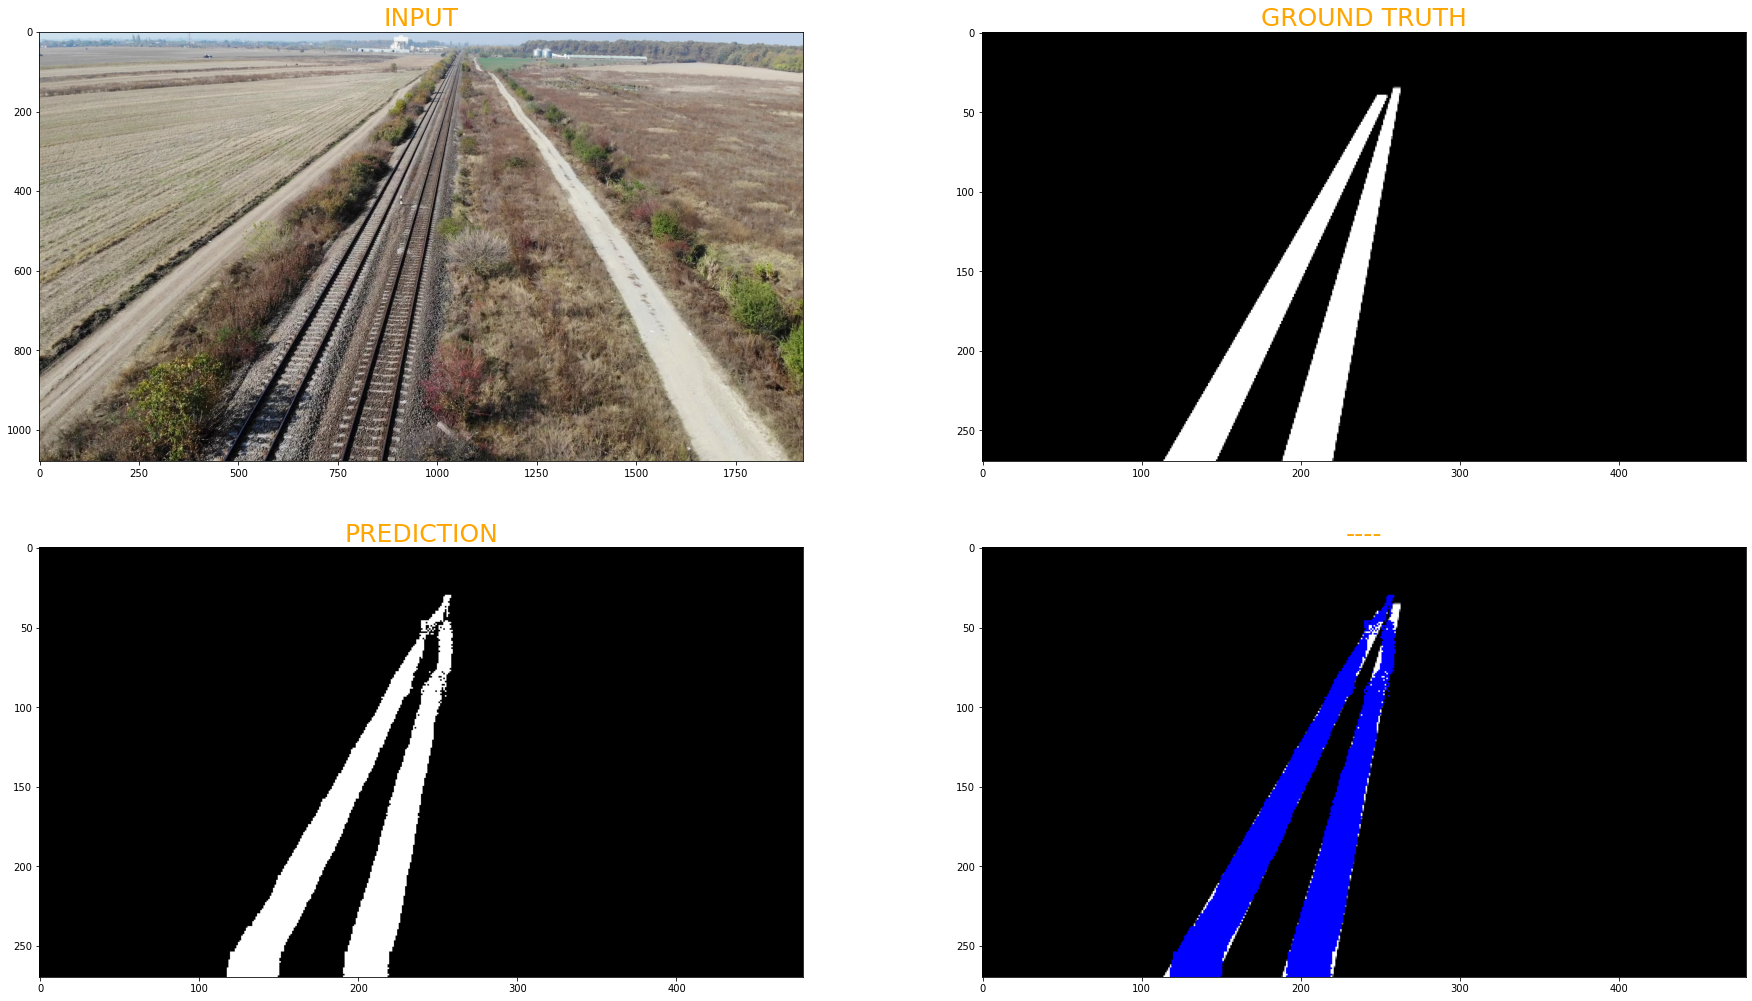

In [ ]:
from random import randrange

import numpy as np
import matplotlib.pyplot as plt


seed = randrange(0, 600)
print('Image index: {}'.format(seed))

N_HEIGHT = 270
N_WIDTH = 480

test_gen_F= DataGeneration(1, (N_HEIGHT, N_WIDTH) , [test_frames[seed]],  [test_ann[seed]])

#model = load_model(D)

with tf.device("/gpu:0"):
    print('Make prediction')
    result = model_predict(model, test_gen_F)

print()
input = cv2.imread(test_frames[seed], 1)
cv2.imwrite('ID.png',input )
input = cv2.resize(input, (N_WIDTH, N_HEIGHT), cv2.INTER_AREA)
gd = cv2.imread(test_ann[seed])
gd = cv2.resize(gd, (N_WIDTH, N_HEIGHT), cv2.INTER_AREA)
cv2.imwrite('GDD.png',gd )


mask = np.argmax(result[0],axis=-1)
mask = np.expand_dims(mask, axis=-1)
p = ImageOps.autocontrast(tensorflow.keras.preprocessing.image.array_to_img(mask))
p.save(os.path.join('PD.png'), 'PNG')

p = cv2.imread('PD.png', 1)

img = gd
for x in range(img.shape[0]):
  for y in range(img.shape[1]):
    if (p[x,y] == 255).all():
      img[x,y] = [0 ,0, 255]


cv2.imwrite('OD.png', img)


fig=plt.figure(figsize=(40, 35))
columns = 2
rows = 2
fig.subplots_adjust(top = 0.5, left = 0.3)

ax1 = fig.add_subplot(rows, columns, 1)
plt.imshow(plt.imread('ID.png'))
ax1.set_title('INPUT', fontsize=25, color='orange')

ax3 = fig.add_subplot(rows, columns,3)
ax3.set_title('PREDICTION', fontsize=25, color='orange')
plt.imshow(cv2.imread('PD.png'))


ax4 = fig.add_subplot(rows, columns, 4)
ax4.set_title('----', fontsize=25, color='orange')
plt.imshow(cv2.imread('OD.png'))


ax2 = fig.add_subplot(rows, columns, 2)
ax2.set_title('GROUND TRUTH', fontsize=25, color='orange')

plt.imshow(cv2.imread('GDD.png'))
plt.show()

##**Get Prediction for VGG16-FCN16S 1/4 size**


Image index: 490
Moels directory: drive/My Drive/Models
Make prediction



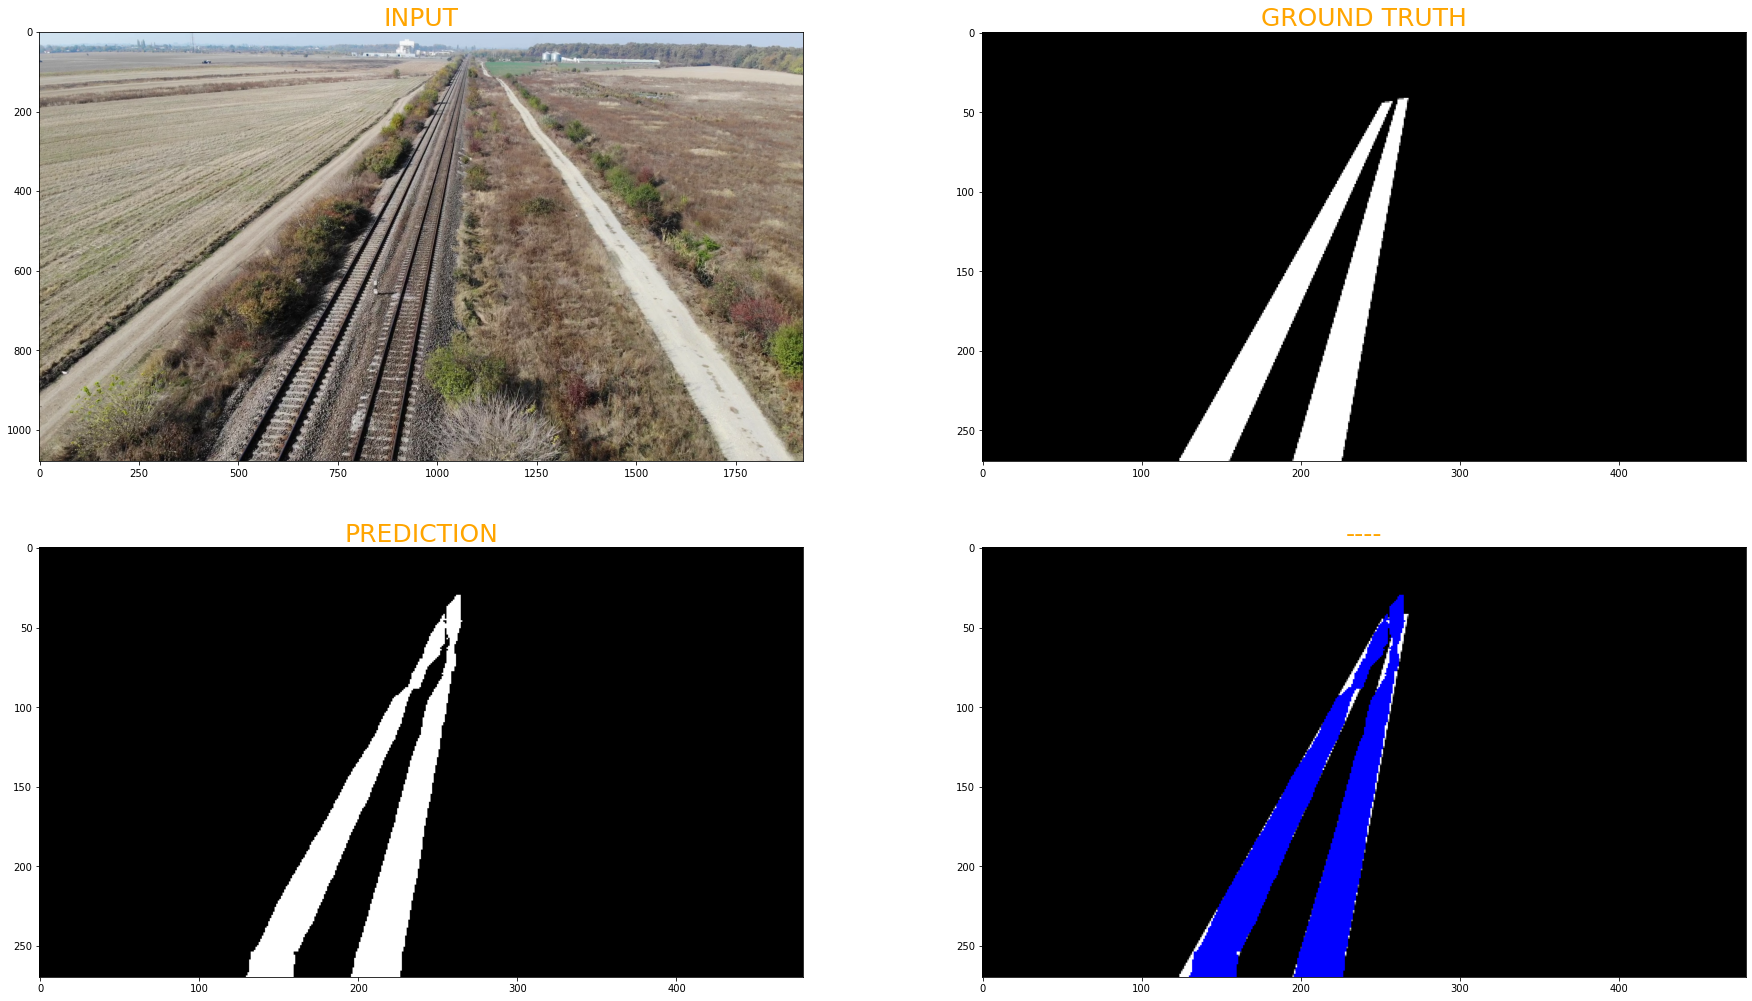

In [ ]:
from random import randrange

import numpy as np
import matplotlib.pyplot as plt


seed = randrange(0, 600)
print('Image index: {}'.format(seed))

N_HEIGHT = 270
N_WIDTH = 480

test_gen_F= DataGeneration(1, (N_HEIGHT, N_WIDTH) , [test_frames[seed]],  [test_ann[seed]])

model = load_model(C)

with tf.device("/gpu:0"):
    print('Make prediction')
    result = model_predict(model, test_gen_F)

print()
input = cv2.imread(test_frames[seed], 1)
cv2.imwrite('IC.png',input )
input = cv2.resize(input, (N_WIDTH, N_HEIGHT), cv2.INTER_AREA)
gd = cv2.imread(test_ann[seed])
gd = cv2.resize(gd, (N_WIDTH, N_HEIGHT), cv2.INTER_AREA)
cv2.imwrite('GDC.png',gd )


mask = np.argmax(result[0],axis=-1)
mask = np.expand_dims(mask, axis=-1)
p = ImageOps.autocontrast(tensorflow.keras.preprocessing.image.array_to_img(mask))
p.save(os.path.join('PC.png'), 'PNG')

p = cv2.imread('PC.png', 1)

img = gd
for x in range(img.shape[0]):
  for y in range(img.shape[1]):
    if (p[x,y] == 255).all():
      img[x,y] = [0 ,0, 255]


cv2.imwrite('OC.png', img)


fig=plt.figure(figsize=(40, 35))
columns = 2
rows = 2
fig.subplots_adjust(top = 0.5, left = 0.3)

ax1 = fig.add_subplot(rows, columns, 1)
plt.imshow(plt.imread('IC.png'))
ax1.set_title('INPUT', fontsize=25, color='orange')

ax3 = fig.add_subplot(rows, columns,3)
ax3.set_title('PREDICTION', fontsize=25, color='orange')
plt.imshow(cv2.imread('PC.png'))


ax4 = fig.add_subplot(rows, columns, 4)
ax4.set_title('----', fontsize=25, color='orange')
plt.imshow(cv2.imread('OC.png'))


ax2 = fig.add_subplot(rows, columns, 2)
ax2.set_title('GROUND TRUTH', fontsize=25, color='orange')

plt.imshow(cv2.imread('GDC.png'))
plt.show()

##**Get Prediction for VGG16-FCN8S 1/4 size**


Image index: 490
Make prediction



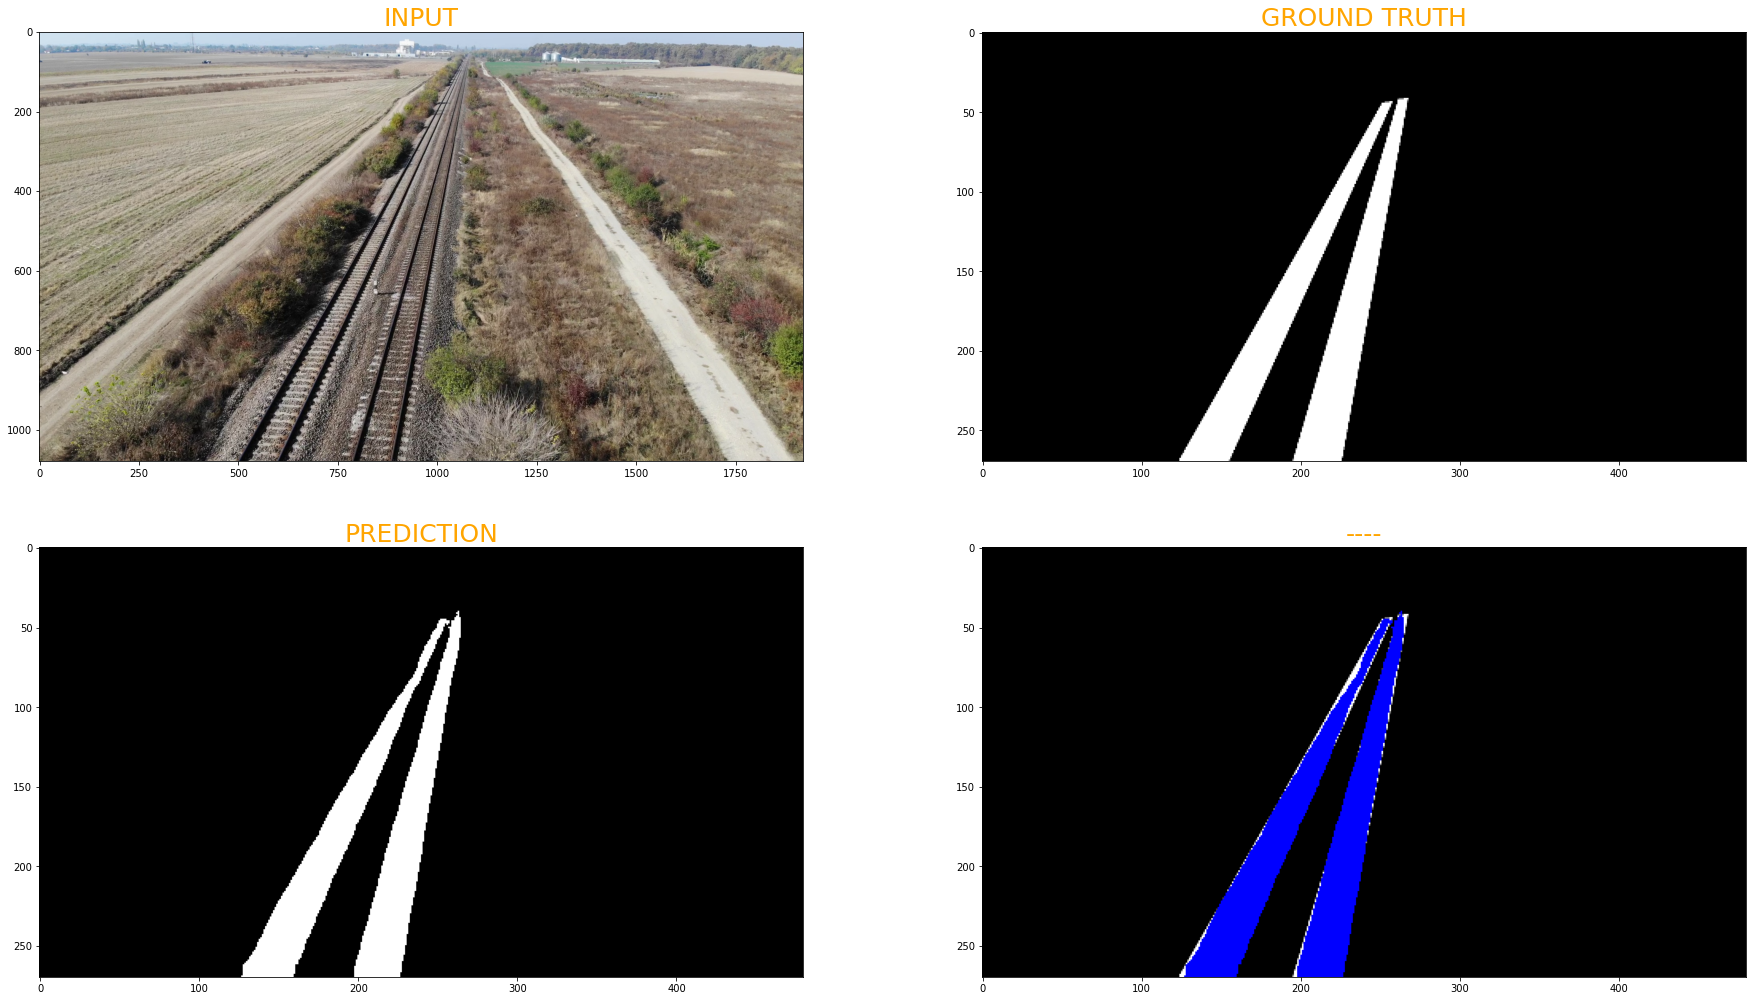

In [ ]:
from random import randrange

import numpy as np
import matplotlib.pyplot as plt


seed = randrange(0, 600)
print('Image index: {}'.format(seed))

N_HEIGHT = 270
N_WIDTH = 480

test_gen_F= DataGeneration(1, (N_HEIGHT, N_WIDTH) , [test_frames[seed]],  [test_ann[seed]])

#model = load_model(A)

with tf.device("/gpu:0"):
    print('Make prediction')
    result = model_predict(model, test_gen_F)

print()
input = cv2.imread(test_frames[seed], 1)
cv2.imwrite('IA.png',input )
input = cv2.resize(input, (N_WIDTH, N_HEIGHT), cv2.INTER_AREA)
gd = cv2.imread(test_ann[seed])
gd = cv2.resize(gd, (N_WIDTH, N_HEIGHT), cv2.INTER_AREA)
cv2.imwrite('GDA.png',gd )


mask = np.argmax(result[0],axis=-1)
mask = np.expand_dims(mask, axis=-1)
p = ImageOps.autocontrast(tensorflow.keras.preprocessing.image.array_to_img(mask))
p.save(os.path.join('PA.png'), 'PNG')

p = cv2.imread('PA.png', 1)

img = gd
for x in range(img.shape[0]):
  for y in range(img.shape[1]):
    if (p[x,y] == 255).all():
      img[x,y] = [0 ,0, 255]


cv2.imwrite('OA.png', img)


fig=plt.figure(figsize=(40, 35))
columns = 2
rows = 2
fig.subplots_adjust(top = 0.5, left = 0.3)

ax1 = fig.add_subplot(rows, columns, 1)
plt.imshow(plt.imread('IA.png'))
ax1.set_title('INPUT', fontsize=25, color='orange')

ax3 = fig.add_subplot(rows, columns,3)
ax3.set_title('PREDICTION', fontsize=25, color='orange')
plt.imshow(cv2.imread('PA.png'))


ax4 = fig.add_subplot(rows, columns, 4)
ax4.set_title('----', fontsize=25, color='orange')
plt.imshow(cv2.imread('OA.png'))


ax2 = fig.add_subplot(rows, columns, 2)
ax2.set_title('GROUND TRUTH', fontsize=25, color='orange')

plt.imshow(cv2.imread('GDA.png'))
plt.show()

##**Get Prediction for RESNET50-FCN8S 1/4 size**


Image index: 146
Moels directory: drive/My Drive/Models
Make prediction



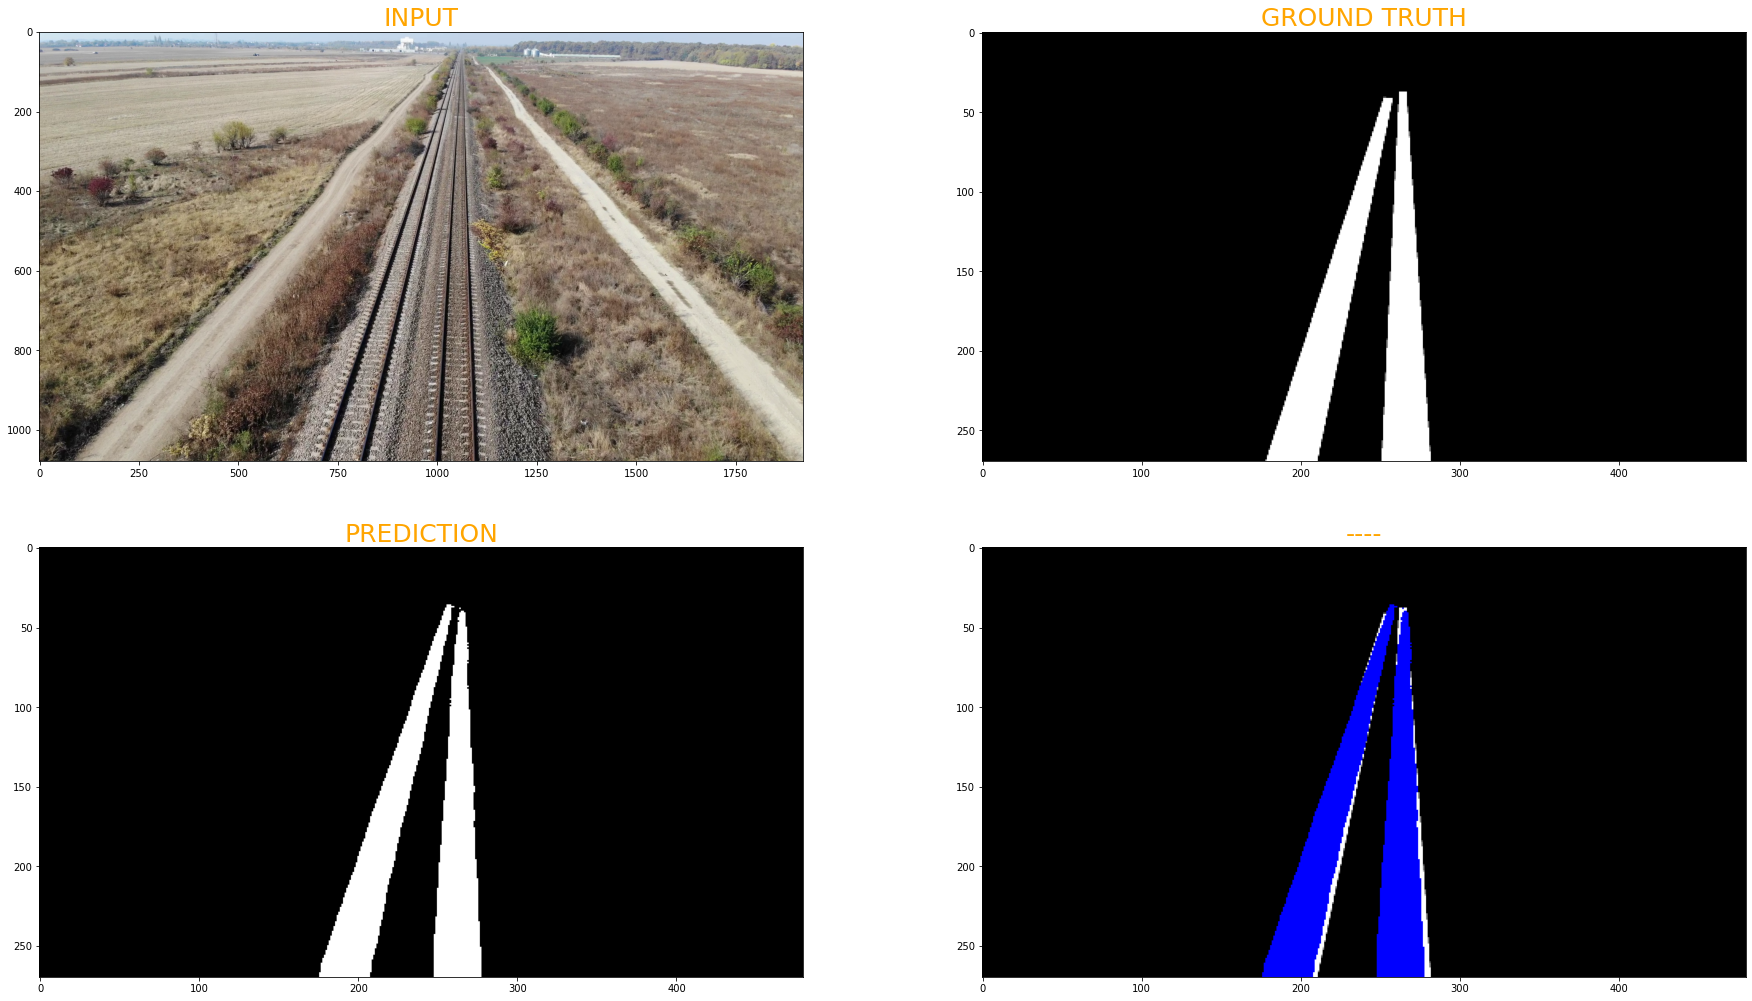

In [ ]:
from random import randrange

import numpy as np
import matplotlib.pyplot as plt


seed = randrange(0, 600)
print('Image index: {}'.format(seed))

N_HEIGHT = 270
N_WIDTH = 480

test_gen_F= DataGeneration(1, (N_HEIGHT, N_WIDTH) , [test_frames[seed]],  [test_ann[seed]])

model = load_model(B)

with tf.device("/gpu:0"):
    print('Make prediction')
    result = model_predict(model, test_gen_F)

print()
input = cv2.imread(test_frames[seed], 1)
cv2.imwrite('IB.png',input )
input = cv2.resize(input, (N_WIDTH, N_HEIGHT), cv2.INTER_AREA)
gd = cv2.imread(test_ann[seed])
gd = cv2.resize(gd, (N_WIDTH, N_HEIGHT), cv2.INTER_AREA)
cv2.imwrite('GDB.png',gd )


mask = np.argmax(result[0],axis=-1)
mask = np.expand_dims(mask, axis=-1)
p = ImageOps.autocontrast(tensorflow.keras.preprocessing.image.array_to_img(mask))
p.save(os.path.join('PB.png'), 'PNG')

p = cv2.imread('PB.png', 1)

img = gd
for x in range(img.shape[0]):
  for y in range(img.shape[1]):
    if (p[x,y] == 255).all():
      img[x,y] = [0 ,0, 255]


cv2.imwrite('OB.png', img)


fig=plt.figure(figsize=(40, 35))
columns = 2
rows = 2
fig.subplots_adjust(top = 0.5, left = 0.3)

ax1 = fig.add_subplot(rows, columns, 1)
plt.imshow(plt.imread('IB.png'))
ax1.set_title('INPUT', fontsize=25, color='orange')

ax3 = fig.add_subplot(rows, columns,3)
ax3.set_title('PREDICTION', fontsize=25, color='orange')
plt.imshow(cv2.imread('PB.png'))


ax4 = fig.add_subplot(rows, columns, 4)
ax4.set_title('----', fontsize=25, color='orange')
plt.imshow(cv2.imread('OB.png'))


ax2 = fig.add_subplot(rows, columns, 2)
ax2.set_title('GROUND TRUTH', fontsize=25, color='orange')

plt.imshow(cv2.imread('GDB.png'))
plt.show()



#**Get predictions for VGG16-FCN8s 1/2 size**



Image index: 90
Moels directory: drive/My Drive/Models
Make prediction



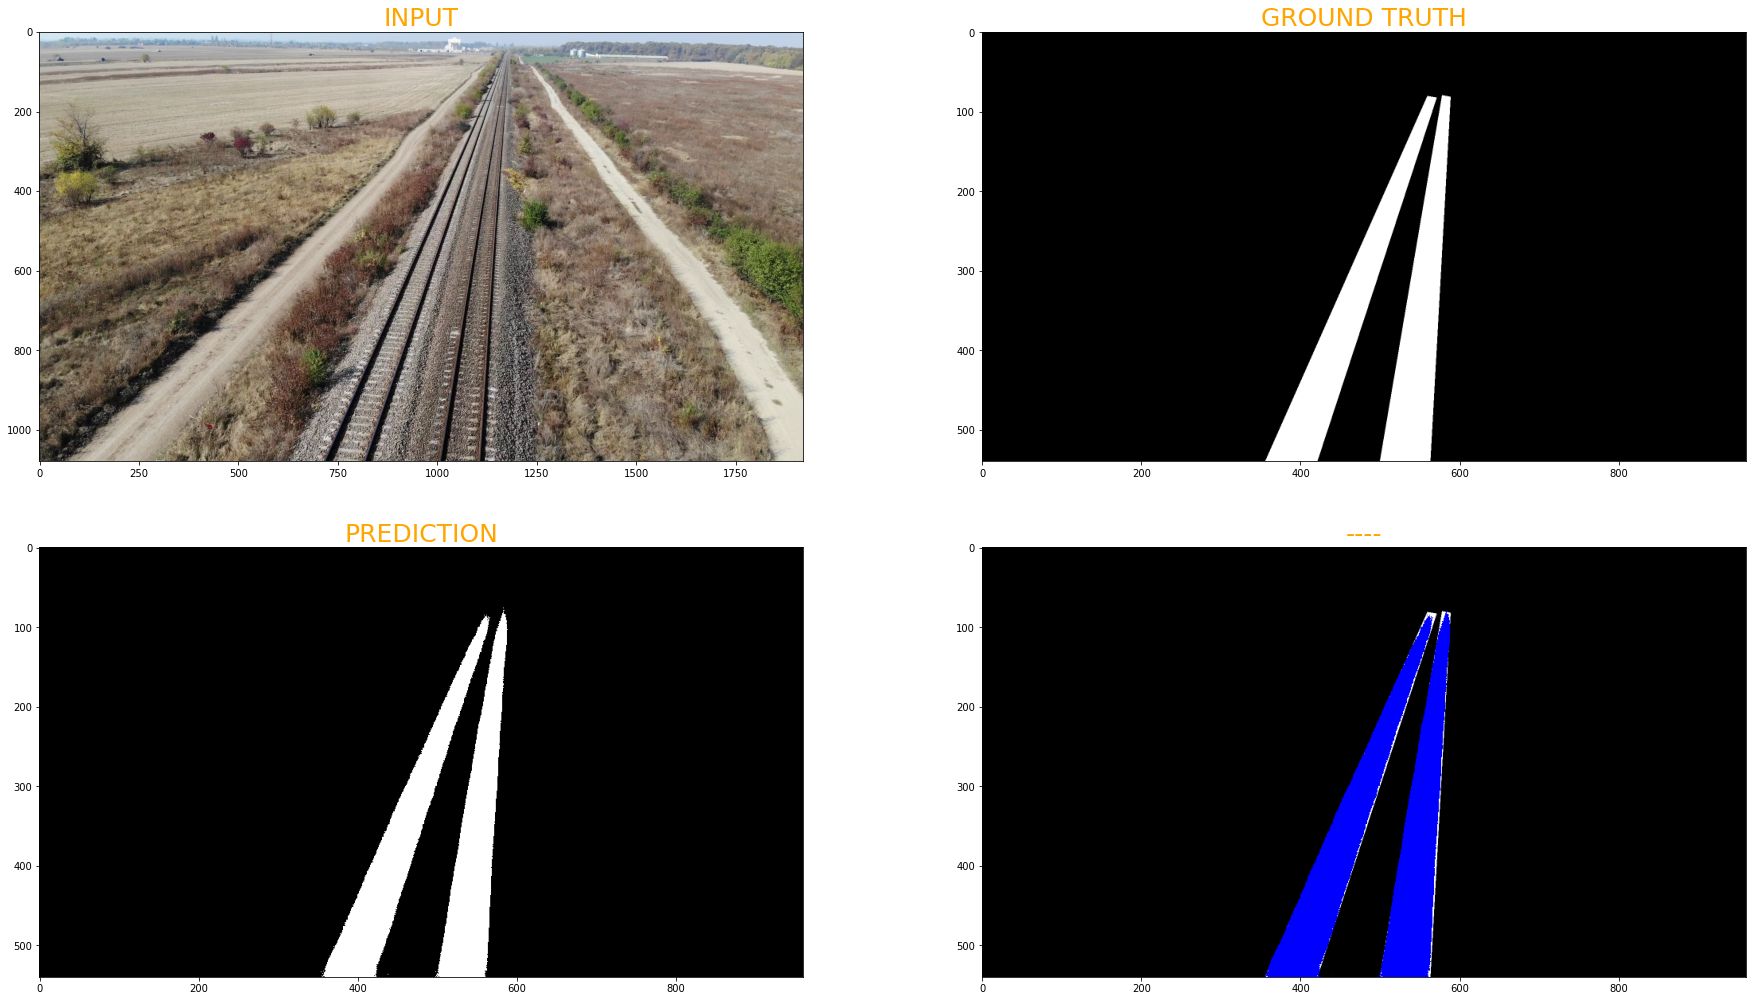

In [ ]:
from random import randrange

import numpy as np
import matplotlib.pyplot as plt


seed = randrange(0, 600)
print('Image index: {}'.format(seed))

N_HEIGHT = 540
N_WIDTH = 960

test_gen_F= DataGeneration(1, (N_HEIGHT, N_WIDTH) , [test_frames[seed]],  [test_ann[seed]])

#model = load_model(E)

with tf.device("/gpu:0"):
    print('Make prediction')
    result = model_predict(model, test_gen_F)

print()
input = cv2.imread(test_frames[seed], 1)
cv2.imwrite('IE.png',input )
input = cv2.resize(input, (N_WIDTH, N_HEIGHT), cv2.INTER_AREA)
gd = cv2.imread(test_ann[seed])
gd = cv2.resize(gd, (N_WIDTH, N_HEIGHT), cv2.INTER_AREA)
cv2.imwrite('GDE.png',gd )


mask = np.argmax(result[0],axis=-1)
mask = np.expand_dims(mask, axis=-1)
p = ImageOps.autocontrast(tensorflow.keras.preprocessing.image.array_to_img(mask))
p.save(os.path.join('PE.png'), 'PNG')

p = cv2.imread('PE.png', 1)

img = gd
for x in range(img.shape[0]):
  for y in range(img.shape[1]):
    if (p[x,y] == 255).all():
      img[x,y] = [0 ,0, 255]


cv2.imwrite('OE.png', img)


fig=plt.figure(figsize=(40, 35))
columns = 2
rows = 2
fig.subplots_adjust(top = 0.5, left = 0.3)

ax1 = fig.add_subplot(rows, columns, 1)
plt.imshow(plt.imread('IE.png'))
ax1.set_title('INPUT', fontsize=25, color='orange')

ax3 = fig.add_subplot(rows, columns,3)
ax3.set_title('PREDICTION', fontsize=25, color='orange')
plt.imshow(cv2.imread('PE.png'))


ax4 = fig.add_subplot(rows, columns, 4)
ax4.set_title('----', fontsize=25, color='orange')
plt.imshow(cv2.imread('OE.png'))


ax2 = fig.add_subplot(rows, columns, 2)
ax2.set_title('GROUND TRUTH', fontsize=25, color='orange')

plt.imshow(cv2.imread('GDE.png'))
plt.show()



#> **Get Prediction for RESNET50-FCN8S 1/2 size**



Image index: 423
Moels directory: drive/My Drive/Models
Make prediction



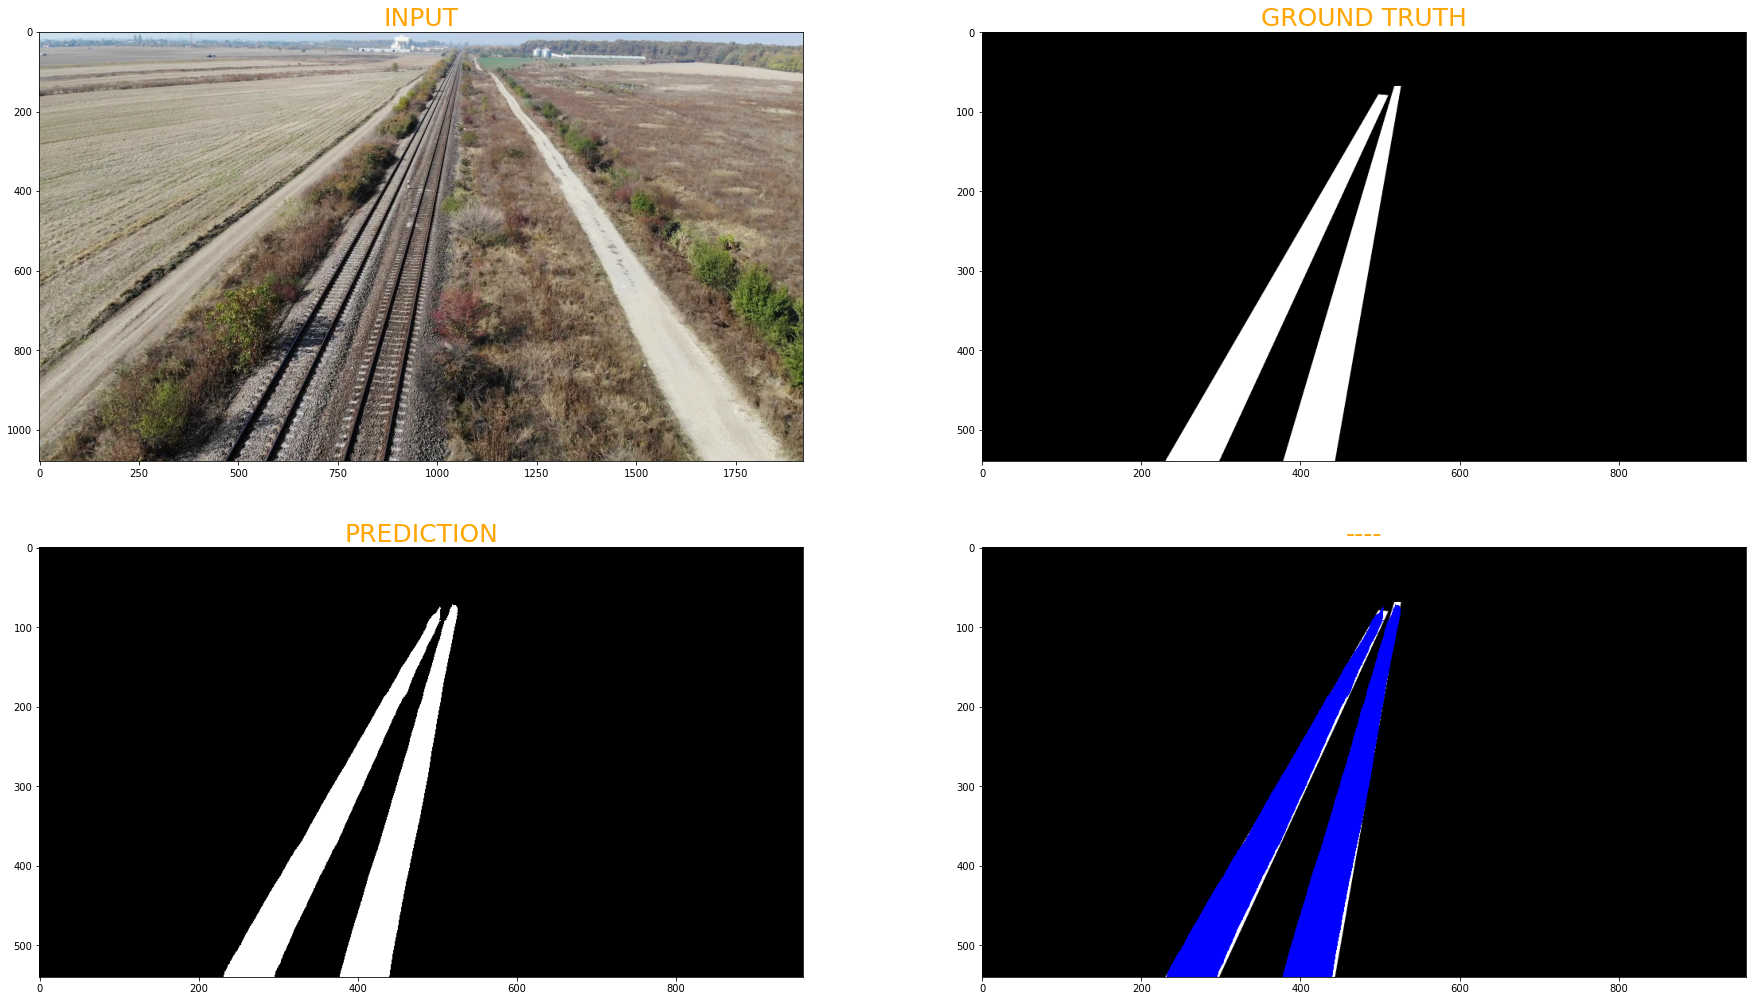

In [ ]:
from random import randrange

import numpy as np
import matplotlib.pyplot as plt


seed = randrange(0, 600)
print('Image index: {}'.format(seed))

N_HEIGHT = 540
N_WIDTH = 960

test_gen_F= DataGeneration(1, (N_HEIGHT, N_WIDTH) , [test_frames[seed]],  [test_ann[seed]])

model = load_model(5)

with tf.device("/gpu:0"):
    print('Make prediction')
    result = model_predict(model, test_gen_F)

print()
input = cv2.imread(test_frames[seed], 1)
cv2.imwrite('IF.png',input )
input = cv2.resize(input, (N_WIDTH, N_HEIGHT), cv2.INTER_AREA)
gd = cv2.imread(test_ann[seed])
gd = cv2.resize(gd, (N_WIDTH, N_HEIGHT), cv2.INTER_AREA)
cv2.imwrite('GDF.png',gd )


mask = np.argmax(result[0],axis=-1)
mask = np.expand_dims(mask, axis=-1)
p = ImageOps.autocontrast(tensorflow.keras.preprocessing.image.array_to_img(mask))
p.save(os.path.join('PF.png'), 'PNG')

p = cv2.imread('PF.png', 1)

img = gd
for x in range(img.shape[0]):
  for y in range(img.shape[1]):
    if (p[x,y] == 255).all():
      img[x,y] = [0 ,0, 255]


cv2.imwrite('OF.png', img)


fig=plt.figure(figsize=(40, 35))
columns = 2
rows = 2
fig.subplots_adjust(top = 0.5, left = 0.3)

ax1 = fig.add_subplot(rows, columns, 1)
plt.imshow(plt.imread('IF.png'))
ax1.set_title('INPUT', fontsize=25, color='orange')

ax3 = fig.add_subplot(rows, columns,3)
ax3.set_title('PREDICTION', fontsize=25, color='orange')
plt.imshow(cv2.imread('PF.png'))


ax4 = fig.add_subplot(rows, columns, 4)
ax4.set_title('----', fontsize=25, color='orange')
plt.imshow(cv2.imread('OF.png'))


ax2 = fig.add_subplot(rows, columns, 2)
ax2.set_title('GROUND TRUTH', fontsize=25, color='orange')

plt.imshow(cv2.imread('GDF.png'))
plt.show()

# **Get Video Capture**


In [ ]:
from random import randrange

import numpy as np
import matplotlib.pyplot as plt


seed = randrange(0, 600)
print('Image index: {}'.format(seed))

N_HEIGHT = 540
N_WIDTH = 960

test_gen_F= DataGeneration(1, (N_HEIGHT, N_WIDTH) , [test_frames[seed]],  [test_ann[seed]])

model = load_model(5)

with tf.device("/gpu:0"):
    print('Make prediction')
    result = model_predict(model, test_gen_F)

print()
input = cv2.imread(test_frames[seed], 1)
cv2.imwrite('IF.png',input )
input = cv2.resize(input, (N_WIDTH, N_HEIGHT), cv2.INTER_AREA)
gd = cv2.imread(test_ann[seed])
gd = cv2.resize(gd, (N_WIDTH, N_HEIGHT), cv2.INTER_AREA)
cv2.imwrite('GDF.png',gd )


mask = np.argmax(result[0],axis=-1)
mask = np.expand_dims(mask, axis=-1)
p = ImageOps.autocontrast(tensorflow.keras.preprocessing.image.array_to_img(mask))
p.save(os.path.join('PF.png'), 'PNG')

p = cv2.imread('PF.png', 1)

img = gd
for x in range(img.shape[0]):
  for y in range(img.shape[1]):
    if (p[x,y] == 255).all():
      img[x,y] = [0 ,0, 255]


cv2.imwrite('OF.png', img)


fig=plt.figure(figsize=(40, 35))
columns = 2
rows = 2
fig.subplots_adjust(top = 0.5, left = 0.3)

ax1 = fig.add_subplot(rows, columns, 1)
plt.imshow(plt.imread('IF.png'))
ax1.set_title('INPUT', fontsize=25, color='orange')

ax3 = fig.add_subplot(rows, columns,3)
ax3.set_title('PREDICTION', fontsize=25, color='orange')
plt.imshow(cv2.imread('PF.png'))


ax4 = fig.add_subplot(rows, columns, 4)
ax4.set_title('----', fontsize=25, color='orange')
plt.imshow(cv2.imread('OF.png'))


ax2 = fig.add_subplot(rows, columns, 2)
ax2.set_title('GROUND TRUTH', fontsize=25, color='orange')

plt.imshow(cv2.imread('GDF.png'))
plt.show()

In [ ]:
# import tensorflow

# seed_t = 1117
# index = 100
# img_2 = 'drive/My Drive/dataset-1/train/frames/frame_2894.png'
# ann_2 = 'drive/My Drive/dataset-1/train/anns/ann_2894.png'

# # random.Random(seed_t).shuffle(test_frames)
# # random.Random(seed_t).shuffle(test_ann)

# print(test_frames[index])
# print(test_ann[index])
# params = [cv2.IMWRITE_PNG_COMPRESSION, 9]


# test_gen_1= DataGeneration(1, (N_HEIGHT, N_WIDTH) , test_frames,  test_ann)
# test_gen_2= DataGeneration(1, (N_HEIGHT, N_WIDTH) ,[img_2] , [ann_2])
# test_gen_3= DataGeneration(1, (N_HEIGHT, N_WIDTH) , [test_frames[index]],  [test_ann[index]])

# model = tensorflow.keras.models.load_model('drive/My Drive/Models/resnte50_fcn16_final', custom_objects={'loss': loss})
# # print('Loaded')
# with tf.device("/gpu:0"):
#     #model_evaluate(model, test_gen_1, 1)
#     print('Predict')
#     results_1 = model_predict(model, test_gen_3)
#     #results_2 = model_predict(model, test_gen_2)

# mask = np.argmax(results_1[0],axis=-1)
# mask = np.expand_dims(mask, axis=-1)
# img = ImageOps.autocontrast(tensorflow.keras.preprocessing.image.array_to_img(mask))

# init_img = cv2.resize(cv2.imread(test_frames[index],1), (480, 270), cv2.INTER_AREA)
# cv2.imwrite(os.path.join('resnet50-fcn16s-input.png'), init_img, params)
# cv2_imshow(init_img)

# display(img)
# #cv2.imwrite(os.path.join('resnet-8s-prediction-1.png'), img, params)


# gd_img = cv2.resize(cv2.imread(test_ann[index],0), (480, 270), cv2.INTER_AREA)
# cv2.imwrite(os.path.join('resnet50-fcn16s-gd3.png'), gd_img, params)
# cv2_imshow(gd_img)

# mask = np.argmax(results_2[0],axis=-1)
# mask = np.expand_dims(mask, axis=-1)
# img = ImageOps.autocontrast(tensorflow.keras.preprocessing.image.array_to_img(mask))

# init_img = cv2.resize(cv2.imread(img_2,1), (480, 270), cv2.INTER_AREA)
# cv2.imwrite(os.path.join('rs-16s-init-22.png'), init_img, params)
# cv2_imshow(init_img)

# display(img)
# img.save(os.path.join('rs-16s-prediction-22.png'), 'PNG')

# gd_img = cv2.resize(cv2.imread(ann_2,0), (480, 270), cv2.INTER_AREA)
# cv2.imwrite(os.path.join('rs-16s-gd-22.png'), gd_img, params)
# cv2_imshow(gd_img)




In [ ]:
# import tensorflow

# seed_t = 1117
# index = 347
# img_2 = 'drive/My Drive/dataset-1/train/frames/frame_2894.png'
# ann_2 = 'drive/My Drive/dataset-1/train/anns/ann_2894.png'

# # random.Random(seed_t).shuffle(test_frames)
# # random.Random(seed_t).shuffle(test_ann)

# print(test_frames[index])
# print(test_ann[index])
# params = [cv2.IMWRITE_PNG_COMPRESSION, 9]


# test_gen_1= DataGeneration(1, (N_HEIGHT, N_WIDTH) , test_frames,  test_ann)
# test_gen_2= DataGeneration(1, (N_HEIGHT, N_WIDTH) ,[img_2] , [ann_2])

# #model = tensorflow.keras.models.load_model('drive/My Drive/Models/vgg16_fcn16_v1', custom_objects={'loss': loss})
# # print('Loaded')
# with tf.device("/gpu:0"):
#     model_evaluate(model, test_gen_1, 1)
#     print('Predict')
#     results_1 = model_predict(model, test_gen_1)
#     results_2 = model_predict(model, test_gen_2)

# mask = np.argmax(results_1[index],axis=-1)
# mask = np.expand_dims(mask, axis=-1)
# img = ImageOps.autocontrast(tensorflow.keras.preprocessing.image.array_to_img(mask))

# init_img = cv2.resize(cv2.imread(test_frames[index],1), (480, 270), cv2.INTER_AREA)
# cv2.imwrite(os.path.join('rs16-16s-init-11.png'), init_img, params)
# cv2_imshow(init_img)

# display(img)
# #cv2.imwrite(os.path.join('resnet-8s-prediction-1.png'), img, params)
# img.save(os.path.join('vgg16-16s-prediction-11.png'), 'PNG')

# gd_img = cv2.resize(cv2.imread(test_ann[index],0), (480, 270), cv2.INTER_AREA)
# cv2.imwrite(os.path.join('rs-16s-gd-11.png'), gd_img, params)
# cv2_imshow(gd_img)

# mask = np.argmax(results_2[0],axis=-1)
# mask = np.expand_dims(mask, axis=-1)
# img = ImageOps.autocontrast(tensorflow.keras.preprocessing.image.array_to_img(mask))

# init_img = cv2.resize(cv2.imread(img_2,1), (480, 270), cv2.INTER_AREA)
# cv2.imwrite(os.path.join('rs-16s-init-22.png'), init_img, params)
# cv2_imshow(init_img)

# display(img)
# img.save(os.path.join('rs-16s-prediction-22.png'), 'PNG')

# gd_img = cv2.resize(cv2.imread(ann_2,0), (480, 270), cv2.INTER_AREA)
# cv2.imwrite(os.path.join('rs-16s-gd-22.png'), gd_img, params)
# cv2_imshow(gd_img)

# latest = tf.train.latest_checkpoint('drive/My Drive/Weights')
# print(latest)



# model.load_weights(latest)




# model.optimizer.lr.assign(1e-4)
# with tf.device("/gpu:0"):
#     hlist = model_train(model, train_gen, test_gen, 11 ,model.name, steps)

  #model_a = get_model(VGG, F

#model.save(os.path.join(directory, model.name))


In [ ]:
import tensorflow

# import tensorflow.keras.losses
# tensorflow.losses.custom_loss = loss

test_gen_1= DataGeneration(1, (N_HEIGHT, N_WIDTH) , test_frames,  test_ann)
# model = tensorflow.keras.models.load_model('drive/My Drive/Models/resnet_fcn8_v2', custom_objects={'loss': loss})
# print('Loaded')
with tf.device("/gpu:0"):
    model_evaluate(model, test_gen_1, 1)
    results = model_predict(model, test_gen_1)


In [ ]:
mask = np.argmax(results[308],axis=-1)
mask = np.expand_dims(mask, axis=-1)
img = ImageOps.autocontrast(tensorflow.keras.preprocessing.image.array_to_img(mask))
display(img)
# tf.keras.backend.clear_session()
# del model


Get VGG16-8S summary

In [ ]:
model_a = get_model(VGG, FCN8, N_CLASSES, name='VGG16-FCN8S', input_shape=INPUT_FORMAT)
display_summary(model_a)

Get RESTNET-8S summary

In [ ]:
model_b = get_model(RESNET, FCN8, N_CLASSES, name='RESNET50-FCN8S', input_shape=INPUT_FORMAT)
display_summary(model_b)